In [1]:
%load_ext autoreload
%autoreload 2

import constants_and_utils as cu
from vaccine_intent import *
from graph_methods import *
from gnn_node_classification import *

import csv
import matplotlib.pyplot as plt
import os
from scipy import sparse
from scipy.stats import pearsonr, linregress
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import auc
import pickle
import geopandas as gpd
import Levenshtein as lv

/home/t-sechang/env/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Overview
This notebook evaluates different steps of the vaccine intent classifier:
1. Propagating labels from vaccine intent queries to URLs via personalized PageRank (S-PPR),
2. Labeling URLs and seed set queries on Amazon Mechanical Turk (AMT),
3. Training graph neural networks (GNNs) on AMT labels and pre-training on S-PPR rankings.

# Results from S-PPR

## Evaluate top nodes from S-PPR

In [2]:
# get top URLs from S-PPR per state
state_names = get_state_names(drop_dc=True)
print(len(state_names))
state2nodes = {}
for state in state_names:
    node_df = load_nodes_to_label_for_state_and_date_range(state, '2months', graph_type='qq_qu', 
                        filter_queries=False, filter_urls=True, verbose=False)
    is_url = node_df.node.apply(lambda x:x.endswith('###URL###'))
    node_df = node_df[is_url]
    assert all(node_df.label == 0)  # all URLs should be unlabeled
    state2nodes[state] = node_df.node.values

50


In [3]:
# print top 10 URLs per state
for state in ['California', 'New York', 'Texas', 'Florida']:
    print(state)
    for rank, url in enumerate(state2nodes[state][:10]):
        print(rank, url.rsplit('_', 1)[0])
    print()

California
0 https://myturn.ca.gov/
1 https://www.cvs.com/immunizations/covid-19-vaccine
2 https://www.goodrx.com/covid-19/walgreens
3 https://www.costco.com/covid-vaccine.html
4 https://www.walgreens.com/topic/promotion/covid-vaccine.jsp
5 http://publichealth.lacounty.gov/acd/ncorona2019/vaccine/HCWSignup/
6 https://www.cdc.gov/vaccines/covid-19/reporting/vaccinefinder/about.html
7 https://www.goodrx.com/covid-19/rite-aid
8 https://www.vaccines.gov/
9 https://www.goodrx.com/covid-19/where-to-get-covid-19-vaccine

New York
0 https://covid19vaccine.health.ny.gov/
1 https://www.cvs.com/immunizations/covid-19-vaccine
2 https://www.walgreens.com/topic/promotion/covid-vaccine.jsp
3 https://vaccinefinder.nyc.gov/
4 https://www.goodrx.com/covid-19/walgreens
5 https://www.cdc.gov/vaccines/covid-19/reporting/vaccinefinder/about.html
6 https://am-i-eligible.covid19vaccine.health.ny.gov/
7 https://www.goodrx.com/covid-19/rite-aid
8 https://www.vaccines.gov/
9 https://corporate.walmart.com/covid-v

In [4]:
# get union of top 100 URLs
top_unlabeled = get_union_of_top_unlabeled_nodes_per_state(state_names, '2months', 100, state2nodes=state2nodes, 
                                           query2count=None, drop_repetitive=True)
top_unlabeled.head()

Union of top N=100 nodes has 2483 nodes (49.66% of max size) -> 100.00% are URL
www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine 266
Keeping: ['https://www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine/Hawaii/Honolulu_###URL###', 'https://www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine/Montana/Billings_###URL###', 'https://www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine/New-Mexico/Albuquerque_###URL###', 'https://www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine/North-Dakota/Fargo_###URL###', 'https://www.cvs.com/store-locator/cvs-pharmacy-locations/covid-vaccine/Alaska/Wasilla_###URL###']
After removing repetitive prefixes...
Union of top N=100 nodes has 2222 nodes (44.44% of max size) -> 100.00% are URL


,node,node_type,num_states,associated_states,min_rank,mean_rank
4,https://www.walgreens.com/topic/promotion/covi...,URL,50,"Alabama, Alaska, Arizona, Arkansas, California...",0,5.46
2,https://corporate.walmart.com/covid-vaccine,URL,50,"Alabama, Alaska, Arizona, Arkansas, California...",1,6.96
6,https://www.vaccines.gov/,URL,50,"Alabama, Alaska, Arizona, Arkansas, California...",1,8.52
7,https://www.goodrx.com/covid-19/walgreens,URL,50,"Alabama, Alaska, Arizona, Arkansas, California...",1,8.10
10,https://www.vaccines.gov/search/,URL,50,"Alabama, Alaska, Arizona, Arkansas, California...",5,19.14


In [5]:
# get seed set queries 
query2count = cu.get_query_to_count()
state2seeds = {}
for state in state_names:
    node_df = load_nodes_to_label_for_state_and_date_range(state, '2months', graph_type='qq_qu', 
                        filter_queries=True, query2count=query2count,
                        filter_urls=False, verbose=False)
    node_df = node_df[node_df.label == 1]  # only keep labeled nodes (ie, seed queries)
    state2seeds[state] = node_df.node.values

In [6]:
# get union of top 5 and bottom 5 seed queries
seed_set_queries = get_union_of_seed_set_nodes_per_state(state_names, '2months', 5, 
                                                         state2nodes=state2seeds)

Union of top and bottom N=5 nodes has 227 nodes (45.40% of max size)


# Results from AMT

In [7]:
# results from all AMT URL batches
results_fns = ['amt_pilot_results.csv',
               'large_amt_pilot_urls_results.csv', 
               'amt_urls_batch1_results.csv', 
               'amt_urls_batch2_results.csv', 
               'amt_urls_batch3_results.csv', 
               'amt_nonconsensus_urls_results.csv',
               'amt_urls_batch4_results.csv',
               'amt_urls_batch5_results.csv',
               'amt_nonconsensus_urls_2_results.csv',
              ]
results = []
for fn in results_fns:
    batch_results = pd.read_csv(os.path.join(cu.PATH_TO_ANNOTATIONS, fn))
    results.append(batch_results)
results = pd.concat(results)

In [8]:
# get prop positive with threshold of 3 vs 2
nodes_df = pd.read_csv(os.path.join(cu.PATH_TO_ANNOTATIONS, 'top_100_unlabeled_urls.csv'))
print('num nodes in top 100 union:', len(nodes_df))
node2rank = dict(zip(nodes_df.node, nodes_df.min_rank))

nodes, labels3 = get_vaccine_intent_labels_from_AMT_results(results, positive_threshold=3, 
                                                            negative_threshold=2)
nodes, labels2 = get_vaccine_intent_labels_from_AMT_results(results, positive_threshold=2, 
                                                            negative_threshold=2)
labeled_node_ranks = [node2rank.get(n, np.nan) for n in nodes]
labeled_df = pd.DataFrame({'node': nodes, 'min_rank': labeled_node_ranks,
                           'label3': labels3, 'label2': labels2}).dropna(subset='min_rank')
print('num labeled nodes within top 100:', len(labeled_df))
print(labeled_df[['label3', 'label2']].mean().round(3))

num nodes in top 100 union: 2222
num labeled nodes within top 100: 1781
label3    0.862
label2    0.899
dtype: float64


20 0.9023
60 0.8089
99 0.7128


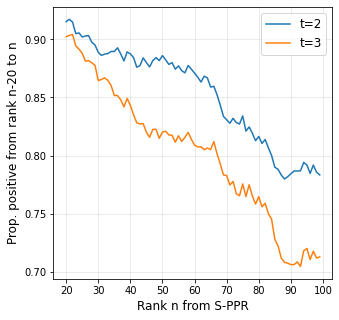

In [9]:
# get prop positive across ranks
interval = 20
starts = np.arange(interval, 100)
prop_positives_3 = []
prop_positives_2 = []
for i in starts:
    ranks = np.arange(i-interval, i+1)
    in_ranks = labeled_df[labeled_df.min_rank.isin(ranks)]
    if len(in_ranks) >= 100:
        prop = (in_ranks.label3 == 1).sum() / len(in_ranks)
        prop_positives_3.append(prop)
        if i in [20, 60, 99]:
            print(i, round(prop, 4))
        prop = (in_ranks.label2 == 1).sum() / len(in_ranks)
        prop_positives_2.append(prop)
    else:
        print('Warning: dropping rank %d, not enough labeled URLs' % i)

plt.figure(figsize=(5,5))
plt.plot(starts, prop_positives_2, label='t=2')
plt.plot(starts, prop_positives_3, label='t=3')
plt.legend(fontsize=12)
plt.xlabel('Rank n from S-PPR', fontsize=12)
plt.ylabel('Prop. positive from rank n-%d to n' % interval, fontsize=12)
plt.grid(alpha=0.3)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'sppr_rank_vs_positive_labels.pdf'), bbox_inches='tight')

In [10]:
# results from seed set queries
results_fns = ['seed_set_queries_results.csv',
               'seed_set_queries_nonconsensus_results.csv']
results = []
for fn in results_fns:
    batch_results = pd.read_csv(os.path.join(cu.PATH_TO_ANNOTATIONS, fn))
    results.append(batch_results)
results = pd.concat(results)
print(len(results))
nodes, labels = get_vaccine_intent_labels_from_AMT_results(results, positive_threshold=3)
print('num labels', len(labels))
print('num pos = %d, num neg = %d, num inconclusive = %d' % (np.sum(labels == 1), np.sum(labels == 0), np.sum(np.isnan(labels))))
print('Percent positive: %.3f' % (np.sum(labels == 1)/len(labels)))
print('Percent positive among conclusive: %.3f' % (np.nanmean(labels)))

727
num labels 227
num pos = 218, num neg = 7, num inconclusive = 2
Percent positive: 0.960
Percent positive among conclusive: 0.969


In [11]:
# print non-positives
'[' + '], ['.join(nodes[labels != 1]) + ']'

'[covid vaccines walgreens], [cvs covid vaccine-19], [meijer covid vaccine], [meijers covid vaccine], [publix.com/covidvaccine], [walgreens.com covid vaccines], [walmart covid shots], [walmart covid vaccine walk-in], [walmart vaccine/covid]'

# Results from GNN

## Evaluate pre-training on S-PPR

In [12]:
# get graph sizes and pretrained states
states = cu.get_state_names(drop_dc=True)
dates = '2months'
pretrained_states = []
state2size = {}
for state in states:
    num_nodes = get_state_graph_size(state)
    state2size[state] = num_nodes
    if num_nodes <= cu.LARGE_STATE_CUTOFF:  # all small states should have pretraining results
        pretrained_states.append(state)
print(len(pretrained_states))
pretrained_states

26


['Alabama',
 'Alaska',
 'Arkansas',
 'Connecticut',
 'Delaware',
 'Hawaii',
 'Idaho',
 'Iowa',
 'Kansas',
 'Kentucky',
 'Louisiana',
 'Maine',
 'Mississippi',
 'Montana',
 'Nebraska',
 'Nevada',
 'New Hampshire',
 'New Mexico',
 'North Dakota',
 'Oklahoma',
 'Rhode Island',
 'South Dakota',
 'Utah',
 'Vermont',
 'West Virginia',
 'Wyoming']

Wyoming: 131 test URLs


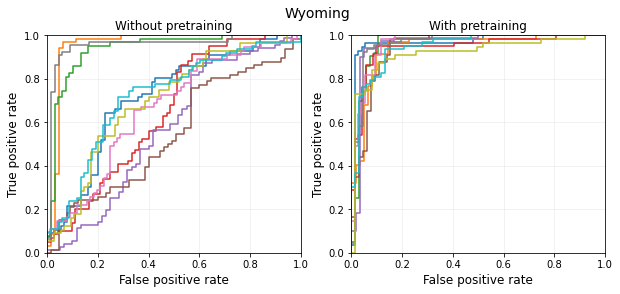

Alaska: 152 test URLs


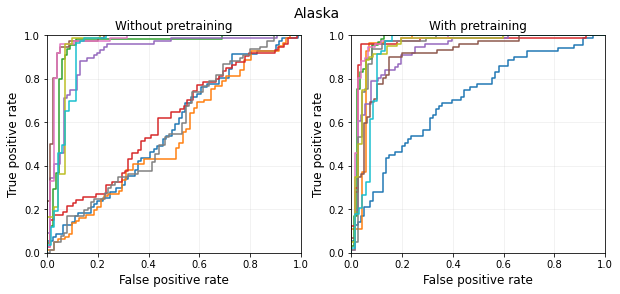

Delaware: 281 test URLs


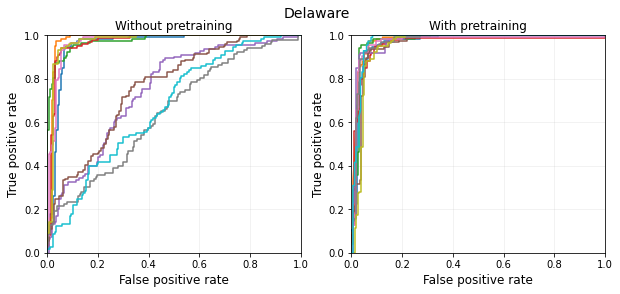

Montana: 244 test URLs


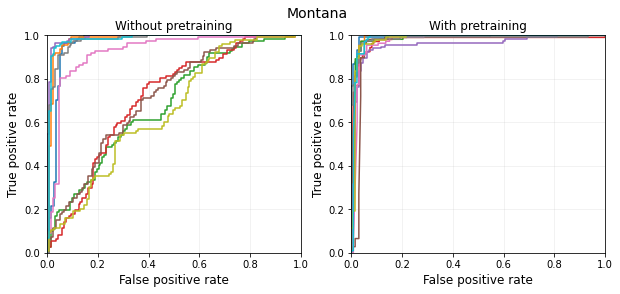

Connecticut: 780 test URLs


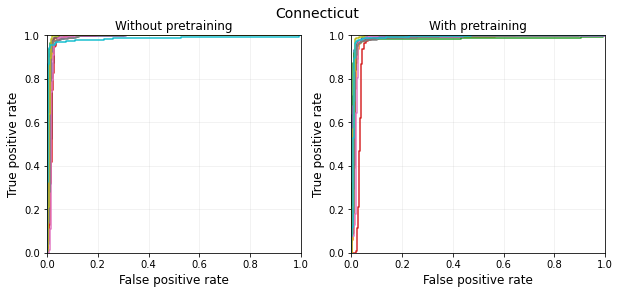

Tennessee: 1058 test URLs


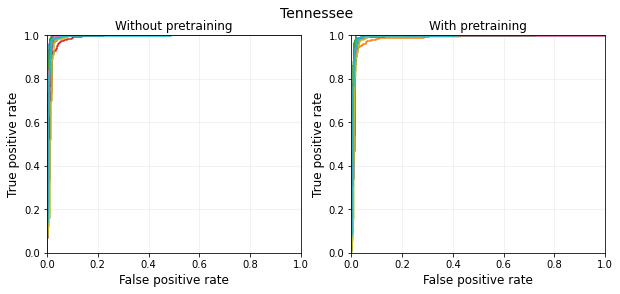

diff     0.092654
ratio    1.116319
dtype: float64


,state,size,mean_auc_with_pretrain,std_auc_with_pretrain,mean_auc_wo_pretrain,std_auc_wo_pretrain,diff,ratio
0,Wyoming,752865,0.951,0.014,0.741,0.146,0.210,1.283
1,Alaska,909357,0.921,0.074,0.796,0.187,0.126,1.158
2,Delaware,1269327,0.968,0.007,0.864,0.134,0.104,1.121
3,Montana,1533071,0.978,0.011,0.857,0.139,0.121,1.141
4,Connecticut,4407722,0.984,0.008,0.987,0.005,-0.003,0.997
5,Tennessee,7712443,0.990,0.003,0.991,0.003,-0.001,0.998


In [25]:
# compare AUCs of GNNs with and without pre-training
auc_table = compare_results_with_and_without_pretraining(cu.STATES_TO_COMPARE, state2size, dates,
                                             num_seeds=10, save_results=False)
auc_table.sort_values('size').round(3)

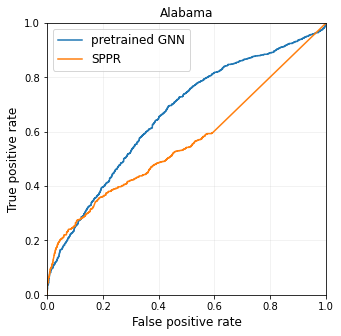

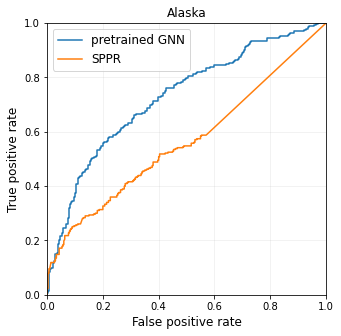

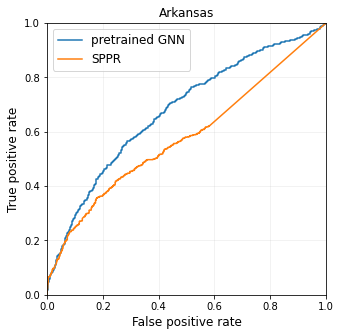

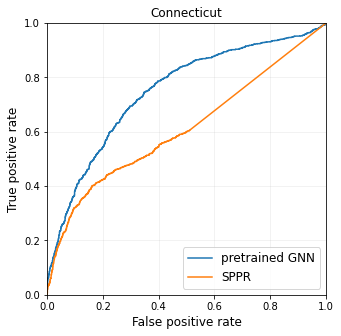

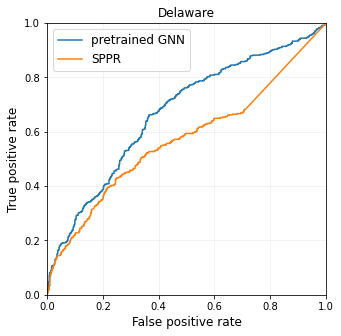

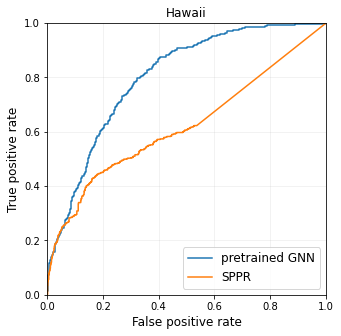

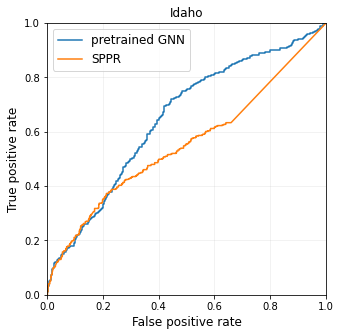

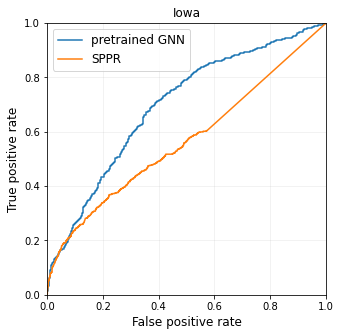

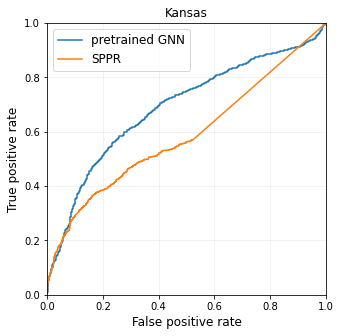

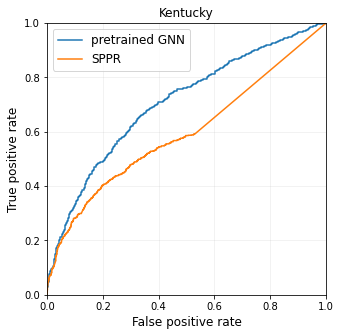

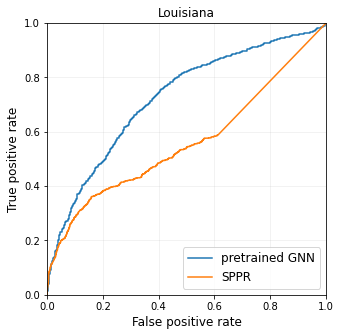

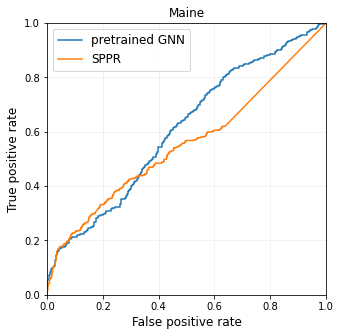

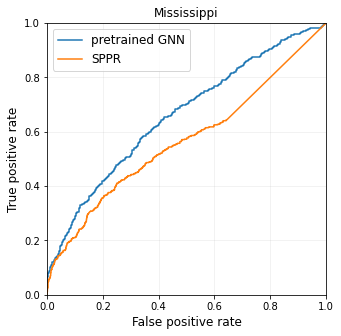

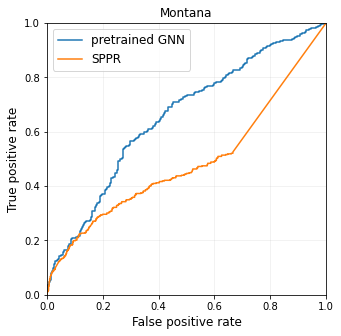

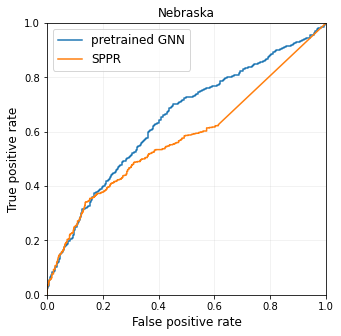

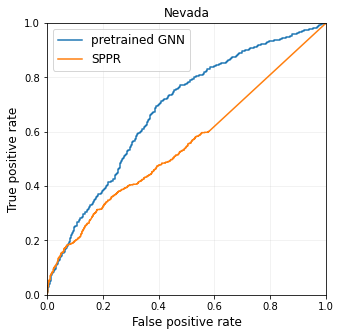

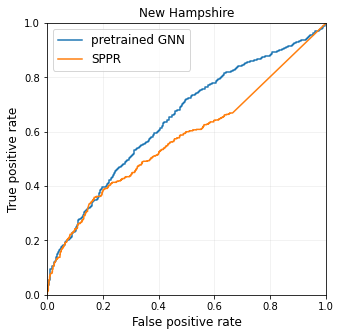

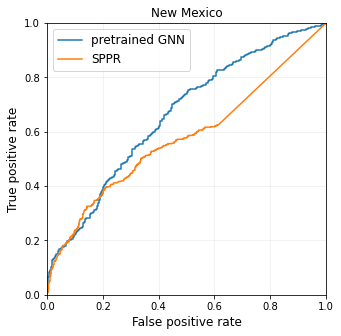

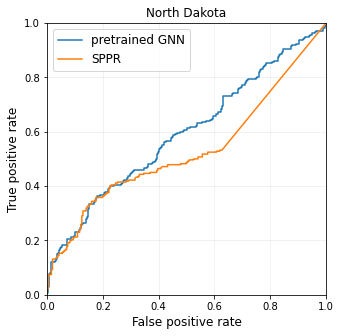

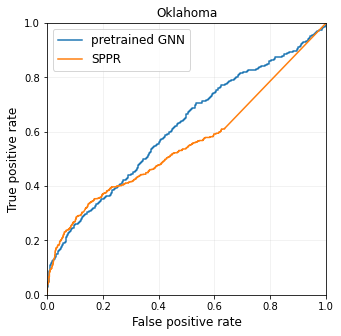

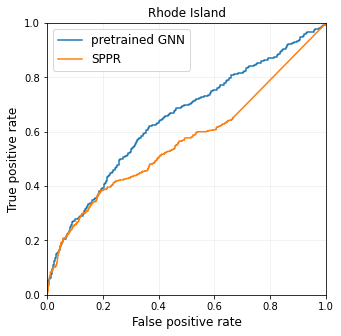

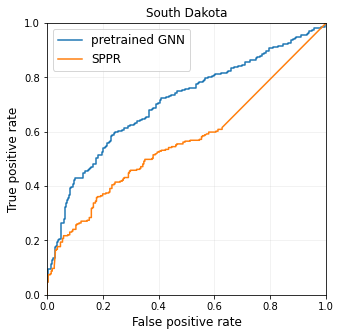

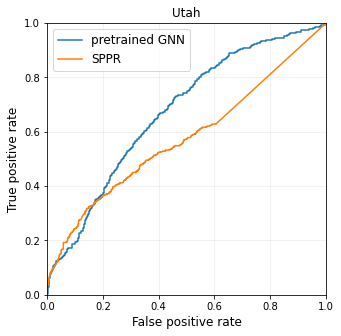

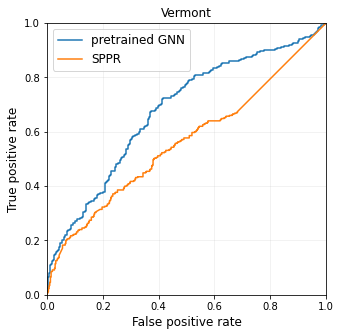

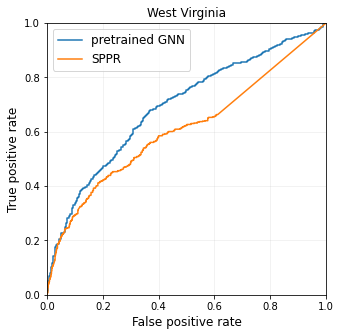

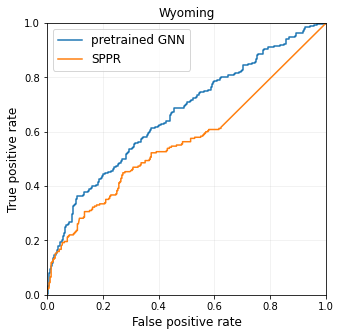

diff     0.106233
ratio    1.187265
dtype: float64


,gnn_pretrained_auroc,sppr_auroc,diff,ratio
count,26.000000,26.000000,26.000000,26.000000
mean,0.675025,0.568792,0.106233,1.187265
std,0.043942,0.025788,0.035463,0.064636
min,0.592309,0.486803,0.053583,1.096743
25%,0.649371,0.559983,0.082790,1.142550
50%,0.670420,0.566598,0.097821,1.172331
75%,0.693944,0.578294,0.127965,1.226779
max,0.799037,0.619988,0.179049,1.342826


In [23]:
# compare AUCs of pre-trained GNN vs S-PPR
auc_table = compare_pretrained_gnn_vs_sppr(pretrained_states, state2size, dates, save_results=False)
auc_table = auc_table.set_index('state')
auc_table[['gnn_pretrained_auroc', 'sppr_auroc', 'diff', 'ratio']].describe()

## Evaluate final GNNs

In [15]:
# get final AUCs, TPRs, and FPRs across states
results_table = compute_final_results_for_all_states(states, dates, state2size, num_seeds=10, 
                                                     state_url2freq=None, verbose=False)
print(results_table[['mean_auc', 'mean_tpr', 'mean_fpr']].describe(percentiles=[0.05, 0.1, 0.25, 0.75, 0.9, 0.95]))
print('%d out of %d states have AUC > 0.95' % ((results_table.mean_auc > 0.95).sum(), 
                                               len(results_table)))

        mean_auc   mean_tpr   mean_fpr
count  50.000000  50.000000  50.000000
mean    0.979250   0.499591   0.011927
std     0.020458   0.008626   0.008120
min     0.902789   0.454969   0.001676
5%      0.932760   0.500132   0.002060
10%     0.951013   0.500243   0.003612
25%     0.973803   0.500505   0.005993
50%     0.985464   0.500934   0.009709
75%     0.992578   0.501710   0.016816
90%     0.994616   0.502487   0.025660
95%     0.996528   0.502909   0.027635
max     0.997410   0.505542   0.035690
45 out of 50 states have AUC > 0.95


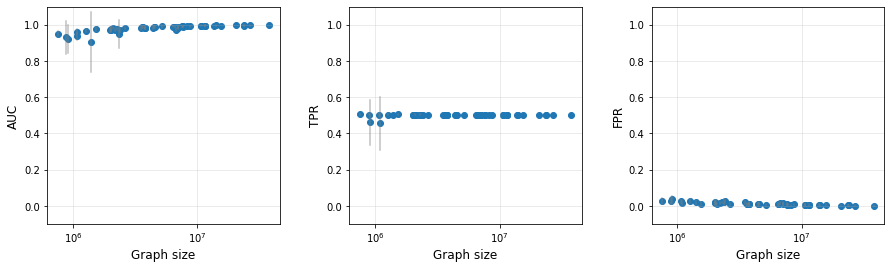

In [16]:
# plot final results
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.subplots_adjust(wspace=0.3)
for metric, ax in zip(['auc', 'tpr', 'fpr'], axes):
    # plot graph size vs metric per state
    ax.scatter(results_table['size'], results_table['mean_%s' % metric])
    ax.set_xscale('symlog')
    ax.set_xlabel('Graph size', fontsize=12)
    ax.set_ylabel('%s' % metric.upper(), fontsize=12)
    ax.set_ylim(-0.1, 1.1)
    ax.grid(alpha=0.3)
    for _, row in results_table.iterrows():
        size, x, se = row['size'], row['mean_%s' % metric], row['se_%s' % metric]
        ax.plot([size, size], [x-se, x+se], color='grey', alpha=0.5)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'results_across_states.pdf'), bbox_inches='tight')

In [17]:
# get new URLs from GNN
url_df, state2urls = get_gnn_expanded_urls('2months', above_median_cutoff=6, above_min_cutoff=6,
                                           verbose=False)

Found 11424 new URLs overall


In [18]:
# print random sample of 20 URLs
sample = url_df.sample(n=20, random_state=0)
for _, row in sample.iterrows():
    print(row['url'])
    print(row[['associated_states', 'max_median_cutoff', 'max_min_cutoff']])
    print()

https://www.chesco.org/4836/61876/COVID-Authorized-Vax
associated_states    Pennsylvania
max_median_cutoff               7
max_min_cutoff                 10
Name: 9321, dtype: object

https://patch.com/new-jersey/princeton/all-information-princeton-area-covid-vaccine-sites
associated_states    New Jersey
max_median_cutoff             9
max_min_cutoff               10
Name: 7258, dtype: object

https://dph.georgia.gov/locations/spalding-county-health-department-covid-vaccine
associated_states    Georgia
max_median_cutoff          9
max_min_cutoff            10
Name: 3532, dtype: object

https://www.abc12.com/2021/04/22/whitmer-says-covid-19-vaccine-clinics-like-flint-church-are-key-to-meeting-goals/
associated_states    Michigan
max_median_cutoff           7
max_min_cutoff             10
Name: 6222, dtype: object

https://www.delta.edu/coronavirus/covid-vaccine.html
associated_states    Michigan
max_median_cutoff          10
max_min_cutoff             10
Name: 5835, dtype: object

https

# Bias evaluation

## S-PPR: compare to combined graph approach

In [19]:
# get union over states
state2nodes = {}
for state in cu.STATES_TO_COMPARE:
    node_df = load_nodes_to_label_for_state_and_date_range(state, '2months', graph_type='qq_qu', 
                        filter_queries=False, filter_urls=True, verbose=False)
    is_url = node_df.node.apply(lambda x:x.endswith('###URL###'))
    node_df = node_df[is_url]
    assert all(node_df.label == 0)  # all URLs should be unlabeled
    state2nodes[state] = node_df.node.values
    
union = get_union_of_top_unlabeled_nodes_per_state(cu.STATES_TO_COMPARE, '2months', 200, 
                                                   state2nodes=state2nodes, 
                                                   query2count=None, drop_repetitive=False, verbose=True)
union.head()

Union of top N=200 nodes has 935 nodes (77.92% of max size) -> 100.00% are URL


,node,node_type,num_states,associated_states,min_rank,mean_rank
74,https://www.cvs.com/immunizations/covid-19-vac...,URL,6,"Alaska, Connecticut, Delaware, Montana, Tennes...",0,34.000000
1,https://www.walgreens.com/topic/promotion/covi...,URL,6,"Alaska, Connecticut, Delaware, Montana, Tennes...",1,8.333333
9,https://www.vaccines.gov/,URL,6,"Alaska, Connecticut, Delaware, Montana, Tennes...",2,10.500000
17,https://www.kroger.com/rx/covid-vaccine,URL,6,"Alaska, Connecticut, Delaware, Montana, Tennes...",2,62.333333
4,https://corporate.walmart.com/covid-vaccine,URL,6,"Alaska, Connecticut, Delaware, Montana, Tennes...",3,7.166667


In [20]:
# get results from S-PPR over combined graph
node_df = load_nodes_to_label_for_state_and_date_range('6states', '2months', graph_type='qq_qu', 
                        filter_queries=False, filter_urls=True, verbose=True)
is_url = node_df.node.apply(lambda x:x.endswith('###URL###'))
node_df = node_df[is_url]
print('Kept %d URLs' % len(node_df))
assert all(node_df.label == 0)  # all URLs should be unlabeled
node_df.head()

Dropping 6012 urls
Kept 17594 URLs


,node,score,rank,label,p
2,https://www.cvs.com/immunizations/covid-19-vac...,0.005841,2,0.0,0.0
3,https://www.walgreens.com/topic/promotion/covi...,0.005240,3,0.0,0.0
4,https://portal.ct.gov/vaccine-portal/COVID-19-...,0.003491,4,0.0,0.0
5,https://www.goodrx.com/covid-19/walgreens_###U...,0.003113,5,0.0,0.0
6,https://corporate.walmart.com/covid-vaccine_##...,0.003070,6,0.0,0.0


intersection 519


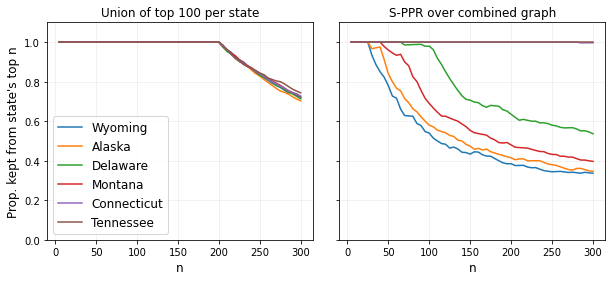

In [21]:
# plot proportion kept per n, across states
union_urls = set(union.node.values)
combined_urls = node_df.iloc[:len(union_urls)].node.values  # same length
combined_urls = set([n.rsplit('_', 1)[0] for n in combined_urls])  # strip URL tag
assert len(union_urls) == len(combined_urls)
print('intersection', len(union_urls.intersection(combined_urls)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
fig.subplots_adjust(wspace=0.1)
ns = np.arange(5, 301, 5)
for state in cu.STATES_TO_COMPARE:
    nodes = [node.rsplit('_', 1)[0] for node in state2nodes[state]]  # strip URL tag
    in_union = []
    in_combined = []
    for n in ns:
        top_n = set(nodes[:n])
        in_union.append(len(union_urls.intersection(top_n)))
        in_combined.append(len(combined_urls.intersection(top_n)))
    axes[0].plot(ns, np.array(in_union) / ns, label=state)
    axes[1].plot(ns, np.array(in_combined) / ns, label=state)
axes[0].set_ylabel('Prop. kept from state\'s top n', fontsize=12)
axes[0].legend(loc='lower left', fontsize=12)
axes[0].set_title('Union of top 100 per state', fontsize=12)
axes[1].set_title('S-PPR over combined graph', fontsize=12)
for ax in axes:
    ax.set_ylim(0, 1.1)
    ax.grid(alpha=0.2)
    ax.set_xlabel('n', fontsize=12)
plt.savefig(os.path.join(PATH_TO_RESULTS, 'union_vs_combined_sppr_results.pdf'), bbox_inches='tight')